In [18]:
import pandas as pd
import os
from os.path import isfile, join
import time
import re
import numpy as np
from tqdm.notebook import tqdm
import pickle
import pandas as pd
import itertools
from collections import Counter
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from gensim.models import word2vec
import os
import string
import spacy
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from scipy.sparse import csr_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [17]:
!pip3 install nltk
!pip3 install vaderSentiment
!pip3 install gensim

  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)


In [9]:
from sklearn.linear_model import LogisticRegression

In [21]:
from sklearn.metrics import roc_auc_score, auc, f1_score, accuracy_score, roc_curve

### Load Data

In [11]:
os.getcwd()

'/home/jovyan/Documents/Master/Winter/MGTA 415/Project/415-final-project-sentiment-analysis-imdb/POS-TermFreq'

In [3]:
os.listdir()

['.DS_Store',
 '.ipynb_checkpoints',
 'Automated_Phrase_Mining_from_Massive_Text_Corpora.pdf',
 'IMDB.ipynb',
 'Reference',
 'acl2020-templates',
 'aclImdb',
 'aclImdb_v1.tar.gz',
 'fake_news_train_clean.csv']

In [5]:
filePath = ["./aclImdb/train/", "./aclImdb/test/"]
'/Users/ryola/Documents/Master/Winter/MGTA\ 415/Project/aclImdb/test'
tag = ["pos/", "neg/"]
for i in filePath:
    for j in tag:
        start = time.time()
        path = i+j
        onlyfiles = [f for f in os.listdir(path) if isfile(join(path, f))]
        end = time.time()
        print(f"Detect {len(onlyfiles)} files at the current path:'{path}', time: {round(end-start, 4)}s.")
# onlyfiles

Detect 12500 files at the current path:'./aclImdb/train/pos/', time: 11.9585s.
Detect 12500 files at the current path:'./aclImdb/train/neg/', time: 10.1574s.
Detect 12500 files at the current path:'./aclImdb/test/pos/', time: 10.813s.
Detect 12500 files at the current path:'./aclImdb/test/neg/', time: 11.4046s.


In [5]:
os.getcwd()

'/home/jovyan/Documents/Master/Winter/MGTA 415/Project/415-final-project-sentiment-analysis-imdb/POS-TermFreq'

In [8]:
%%time
testPosPath = '/home/jovyan/Documents/Master/Winter/MGTA 415/Project/aclImdb/test/pos/'
testNegPath = '/home/jovyan/Documents/Master/Winter/MGTA 415/Project/aclImdb/test/neg/'
testfiles = [f for f in os.listdir(testPosPath) if isfile(join(testPosPath, f))]
testfiles += [f for f in os.listdir(testNegPath) if isfile(join(testNegPath, f))]

CPU times: user 1.22 s, sys: 1.84 s, total: 3.05 s
Wall time: 22.1 s


In [11]:
%%time
Xtest = []
ytest = [1] * 12500 + [0] * 12500
# filedir = "./aclImdb/test/neg/"
start = time.time()
for i in range(len(testfiles)):
    file = testfiles[i]
    if i < 12500:
        filedir = "/home/jovyan/Documents/Master/Winter/MGTA 415/Project/aclImdb/test/pos/"
    else:
        filedir = "/home/jovyan/Documents/Master/Winter/MGTA 415/Project/aclImdb/test/neg/"
    path = filedir + file
    rating = re.findall("[0-9]+_([0-9]+).txt", file)[0]
    with open(path, "r") as f:
        contents = f.read()
        Xtest.append([contents, rating])
end = time.time()
# print("Time :{}s.".format(round(end- start, 4)))

CPU times: user 2.91 s, sys: 9.7 s, total: 12.6 s
Wall time: 1min


In [12]:
test = pd.DataFrame(Xtest, columns = ["text", 'rating'])
test['label'] = ytest
print(test.shape)
test.head()

(25000, 3)


,text,rating,label
0,I went and saw this movie last night after bei...,10,1
1,Actor turned director Bill Paxton follows up h...,7,1
2,As a recreational golfer with some knowledge o...,9,1
3,"I saw this film in a sneak preview, and it is ...",8,1
4,Bill Paxton has taken the true story of the 19...,8,1


In [26]:
%%time
trainPosPath = '/home/jovyan/Documents/Master/Winter/MGTA 415/Project/aclImdb/train/pos/'
trainNegPath = '/home/jovyan/Documents/Master/Winter/MGTA 415/Project/aclImdb/train/neg/'
trainfiles = [f for f in os.listdir(trainPosPath) if isfile(join(trainPosPath, f))]
trainfiles += [f for f in os.listdir(trainNegPath) if isfile(join(trainNegPath, f))]

CPU times: user 3.71 s, sys: 0 ns, total: 3.71 s
Wall time: 23.4 s


In [30]:
%%time
Xtrain = []
ytrain = [1] * 12500 + [0] * 12500
# filedir = "./aclImdb/test/neg/"
start = time.time()
for i in range(len(trainfiles)):
    file = trainfiles[i]
    if i < 12500:
        filedir = "/home/jovyan/Documents/Master/Winter/MGTA 415/Project/aclImdb/train/pos/"
    else:
        filedir = "/home/jovyan/Documents/Master/Winter/MGTA 415/Project/aclImdb/train/neg/"
    path = filedir + file
    rating = re.findall("[0-9]+_([0-9]+).txt", file)[0]
    with open(path, "r") as f:
        contents = f.read()
        Xtrain.append([contents, rating])
end = time.time()
print("Time :{}s.".format(round(end- start, 4)))

Time :64.0791s.
CPU times: user 6 s, sys: 6.7 s, total: 12.7 s
Wall time: 1min 4s


In [31]:
train = pd.DataFrame(Xtrain, columns = ["text", 'rating'])
train['label'] = ytrain
print(train.shape)
train.head()

(25000, 3)


,text,rating,label
0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,Homelessness (or Houselessness as George Carli...,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,This is easily the most underrated film inn th...,7,1
4,This is not the typical Mel Brooks film. It wa...,8,1


### Basic Info About Train Set

In [32]:
Xtrain[0]

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
 '9']

In [33]:
doc_lens = []
for doc in Xtrain:
    l = len(doc[0].split())
    doc_lens.append(l)
lens = np.array(doc_lens)
print(lens.shape, lens.mean())

(25000,) 233.7872


In [34]:
print(lens.max(), lens.min())

2470 10


In [37]:
# avg doc lengths for pos & neg samples
lens[:12500].mean().round(), lens[12500:].mean().round()

(237.0, 231.0)

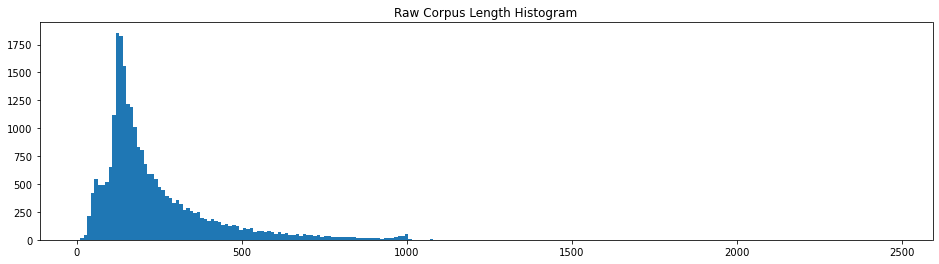

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (16,4))
plt.title("Raw Corpus Length Histogram")
_ = plt.hist(lens, bins='auto')
plt.savefig('data/raw_corpus_length_hist')
plt.show()

### Baseline using VADER

In [13]:
def get_polarity_label(sentence):
    score = sentiment_analyzer.polarity_scores(sentence)
    neg, neu, pos = score['neg'], score['neu'], score['pos']
    if pos >= neg: #and pos > neu:
        return 1 #'positive'
    else:
    #if neg > pos and neg > neu:
        return 0 #'negative'
    # return 'neutral'
# get_polarity_label('I feel good')

In [19]:
test['vader'] = test.text.apply(lambda x: get_polarity_label(x))
test.vader.mean()

0.67668

In [22]:
accuracy_score(test.label, test.vader), f1_score(test.label, test.vader)

(0.69292, 0.7390284529353776)

In [24]:
test[['label', 'vader']].to_csv("../data/res/vader.csv", index = False)

### Preprocess

In [20]:
def preprocess_df(df, col = "text", target_col = 'clean_text'):
    # get English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    # prepare translation table to translate punctuation to space
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row[col]
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1] # also skip space from above translation
        preprocessed_sentences.append(" ".join(filtered_words))
    df[target_col] = preprocessed_sentences
    return df

In [29]:
train = preprocess_df(train)
test = preprocess_df(test)

In [32]:
import en_core_web_sm
import re
nlp_processor = en_core_web_sm.load()
nltk.download('stopwords') # <--- this is new
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
def pre_processing_by_spacy(doc, lemma = True, need_sent = False):
    doc_class = nlp_processor(doc)
    tokens = []
    # step 1: get sentences
    for sent in doc_class.sents:
        # step 2: get tokens
        # step 3 (optional): lemma
        if lemma:
            words = [token.lemma_ for token in sent]
        else:
            words = [token.text for token in sent]
        if need_sent:
            tokens.append(words)
        else:
            tokens += words
            
    raw_corpus = re.sub(r'[^\w\s]', ' ', ' '.join(tokens)).split()
    corpus = [w.lower() for w in raw_corpus if w.lower() not in stop]
    
    return corpus

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
# tokenization -> preprocess by spacy 
tagged_data = [pre_processing_by_spacy(_d) for i, _d in tqdm(enumerate(train["clean_text"]))]

0it [00:00, ?it/s]

In [94]:
# tokenization -> preprocess by spacy 
tagged_test_data = [pre_processing_by_spacy(_d) for i, _d in tqdm(enumerate(test["clean_text"]))]

0it [00:00, ?it/s]

In [95]:
# save tagged train data
with open("data/tagged_train_data.txt", "w") as f:
    for s in tqdm(tagged_data):
        f.write(str(s) +"\n")
with open("data/tagged_test_data.txt", "w") as f:
    for s in tqdm(tagged_test_data):
        f.write(str(s) +"\n")

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

### Rule-based

In [100]:
ypred1 = []
for l in tqdm(tagged_test_data):
    dct = sentiment_analyzer.polarity_scores(' '.join(l))
    if dct['pos'] >= dct['neg']:
        ypred1.append(1)
    else:
        ypred1.append(0)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [101]:
print(accuracy_score(ytest, ypred1))

0.67156


In [102]:
ypred1 = []
for l in tqdm(train.clean_text):
    dct = sentiment_analyzer.polarity_scores(l)
    if dct['pos'] >= dct['neg']:
        ypred1.append(1)
    else:
        ypred1.append(0)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [103]:
print(accuracy_score(ytest, ypred1))

0.67172


### Binary Encoding For Adj + Adv

In [107]:
tagged_sents = []
tags = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBs']
for i in tqdm(range(len(tagged_data))):
    tagged_sents+= [w for w, tag in pos_tag(tagged_data[i]) if tag in tags]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [108]:
vocab = list(set(tagged_sents))
print("Size of adj/adv vocab = {}".format(len(vocab)))

Size of adj/adv vocab = 31974


In [117]:
Xtrain = []
for tokens in tqdm(tagged_data):
    s = list(set(tokens))
    Xtrain.append([s.count(w) for w in vocab])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [118]:
Xtest = []
for tokens in tqdm(tagged_test_data):
    s = list(set(tokens))
    Xtest.append([s.count(w) for w in vocab])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [119]:
# save tagged train data
with open("data/Xtrain_sent_bin.txt", "w") as f:
    for s in tqdm(Xtrain):
        f.write(str(s) +"\n")
with open("data/Xtest_sent_bin.txt", "w") as f:
    for s in tqdm(Xtest):
        f.write(str(s) +"\n")

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [5]:
trans_dict = {"[": "", ',':"", "]":""}
translator = str.maketrans(trans_dict)
ytrain = [1] * 12500 + [0] * 12500
ytest = ytrain
Xtrain = []
Xtest = []
with open("data/Xtrain_sent_bin.txt", "r") as f:
    for line in tqdm(f):
        Xtrain.append(line.translate(translator).split())

0it [00:00, ?it/s]

In [6]:
with open("data/Xtest_sent_bin.txt", "r") as f:
    for line in tqdm(f):
        Xtest.append(line.translate(translator).split())

0it [00:00, ?it/s]

In [ ]:
%%time
# Xtrain_ = csr_matrix(Xtrain)
# Xtest_ = csr_matrix(Xtest)
print("====START FITING REGRESSION====")
clf = LogisticRegression(C = 20)
clf.fit(Xtrain, ytrain)

In [ ]:
def evaluate(ytest, ypred, name):
    accu = accuracy_score(ytest, ypred)
    f1 = f1_score(ytest, ypred)
    AUC = roc_auc_score(ytest, ypred)
    fpr, tpr = roc_curve(ytest, ypred)
    
    lw = 2
    plt.figure(figsize = (6,6))
    plt.plot(fpr, tpr, lw = lw, label="ROC curve of model {}, AUC = ({1:0.2f})".format(name, AUC))
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    df = pd.DataFrame()
    df.assign(
        model = name,
        accuracy = [accu],
        f1_score = [f1],
        AUC = [AUC]
    )
    print(df)
    return df

In [ ]:
ypred2 = clf.predict(Xtest)
evaluate(ytest, ypred2)

In [54]:
sentiment_analyzer = SentimentIntensityAnalyzer()
scores = sentiment_analyzer.lexicon

In [63]:
a = scores.get("1")
[a]

[None]

In [69]:
tagged_adj_sent = []
for i in tqdm(range(len(tagged_adj))):
    l = []
    for w in tagged_adj[i]:
        if scores.get(w) is not None:
            l.append(w)
    tagged_adj_sent.append(l)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [79]:
tagged_adj = []
for i in tqdm(range(len(tagged_adj_sent))):
    tagged_adj.append([scores[w] for w in tagged_adj_sent[i]])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [81]:
np.array(tagged_adj)

/tmp/ipykernel_7613/526094466.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(tagged_adj)


array([list([-2.7]), list([2.6, 0.3, 2.6, 0.1, 2.1, -1.7, -2.4, 2.6]),
       list([2.8, 3.2, 3.2, 1.9, -2.7, 1.9, 2.0, 2.6, 1.1]), ...,
       list([1.3, 1.8, 1.2, 1.3, -0.7, -0.8, -1.8, 2.3, 1.1, 1.9, 2.2, 1.9, -0.7, 2.7, -1.4, -1.8, -1.0, -2.5]),
       list([1.9, 3.1, 2.6, -1.9, -2.5, -2.5, 2.6, 0.7, -2.5, -2.0, -2.0]),
       list([1.9, 1.9, 2.0, -1.9])], dtype=object)

In [96]:
ypred1 = []
for l in tqdm(tagged_test_data):
    dct = sentiment_analyzer.polarity_scores(' '.join(l))
    if dct['pos'] >= dct['neg'] - 0.1:
        ypred1.append(1)
    else:
        ypred1.append(0)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [97]:
print(accuracy_score(ytest, ypred1))

0.58008
